In [1]:
import spotipy
import spotipy.oauth2 as oauth2
import configparser
import pandas as pd
from dateutil.parser import parse as parse_date
import numpy as np
import seaborn as sns
import ast
from typing import List
from os import listdir

# Getting Streaming History 
### making it into something more palatable

In [2]:
def get_streamings(path: str = 'MyData') -> List[dict]:
    
    files = ['MyData/' + x for x in listdir(path)
             if x.split('.')[0][:-1] == 'StreamingHistory']
    
    all_streamings = []
    
    for file in files: 
        with open(file, 'r', encoding='UTF-8') as f:
            new_streamings = ast.literal_eval(f.read())
            all_streamings += [streaming for streaming 
                               in new_streamings]
    return all_streamings

In [3]:
streamings = get_streamings()

In [135]:
import requests
def get_id(track_name, token):
    headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
        }
    params = [
    ('q', track_name),
    ('type', 'track'),
    ]
    try:
        response = requests.get('https://api.spotify.com/v1/search', 
                    headers = headers, params = params, timeout = 5)
        json = response.json()
        first_result = json['tracks']['items'][0]
        track_id = first_result['id']
        return track_id
    except:
        return None

In [15]:
def get_features(track_id, token):
    sp = spotipy.Spotify(auth=token)
    try:
        features = sp.audio_features([track_id])
        return features[0]
    except:
        return None

In [16]:
config = configparser.ConfigParser()
config.read('/Users/kunal/Projects/spotify/config.cfg')
client_id = config.get('SPOTIFY', 'CLIENT_ID')
client_secret = config.get('SPOTIFY', 'CLIENT_SECRET')


auth = oauth2.SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)

token = auth.get_access_token()
spotify = spotipy.Spotify(auth=token)
sp = spotipy.Spotify(client_credentials_manager=auth)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  if sys.path[0] == '':


In [17]:
unique_tracks = list(set([streaming['trackName'] for streaming in streamings]))

all_features = {}
for track in unique_tracks:
    track_id = get_id(track, token)
    features = get_features(track_id, token)
    if features:
        all_features[track] = features
        
with_features = []
for track_name, features in all_features.items():
    with_features.append({'name': track_name, **features})

In [41]:
from collections import Counter
allsongs = list([streaming['trackName'] for streaming in streamings])
dist = Counter(allsongs)

In [49]:
frequency_song = pd.DataFrame.from_dict(dist, orient='index').reset_index()
frequency_song = frequency_song.rename(columns={'index':'name', 0:'count'})

In [50]:
frequency_song.head()

,name,count
0,These Days,25
1,Alright,7
2,"Down Bad (feat. JID, Bas, J. Cole, EARTHGANG &...",16
3,Under The Sun (with J. Cole & Lute feat. DaBaby),32
4,LamboTruck (with Cozz feat. REASON & Childish ...,3


In [51]:
df = pd.DataFrame(with_features)

In [52]:
df.head()

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,No Sweat (feat. Ludacris),0.448,0.830,3,-3.066,0,0.3040,0.348000,0.000000,0.5080,0.4680,91.160,audio_features,6xfLBXKNw5XV40StJmtiWL,spotify:track:6xfLBXKNw5XV40StJmtiWL,https://api.spotify.com/v1/tracks/6xfLBXKNw5XV...,https://api.spotify.com/v1/audio-analysis/6xfL...,166983,4
1,Archangel,0.541,0.948,1,-7.271,0,0.1440,0.000134,0.000000,0.3240,0.1290,114.955,audio_features,7CeTNlKnCbNBzkXA7nmcVG,spotify:track:7CeTNlKnCbNBzkXA7nmcVG,https://api.spotify.com/v1/tracks/7CeTNlKnCbNB...,https://api.spotify.com/v1/audio-analysis/7CeT...,311054,4
2,Dulce,0.158,0.153,4,-19.448,1,0.0346,0.679000,0.901000,0.1080,0.0655,89.467,audio_features,4xYu3ms4RRPwYjoZV7qEPl,spotify:track:4xYu3ms4RRPwYjoZV7qEPl,https://api.spotify.com/v1/tracks/4xYu3ms4RRPw...,https://api.spotify.com/v1/audio-analysis/4xYu...,245514,5
3,Dear Gemini,0.840,0.579,1,-3.950,1,0.0890,0.070100,0.000136,0.0802,0.5640,91.992,audio_features,0hkfcnIuNWHqgZArp9RrIG,spotify:track:0hkfcnIuNWHqgZArp9RrIG,https://api.spotify.com/v1/tracks/0hkfcnIuNWHq...,https://api.spotify.com/v1/audio-analysis/0hkf...,158630,4
4,BRUH?!,0.906,0.888,2,-7.275,1,0.1520,0.182000,0.000000,0.9340,0.7560,105.991,audio_features,7F6oEeRgjOoesYz8qOov7p,spotify:track:7F6oEeRgjOoesYz8qOov7p,https://api.spotify.com/v1/tracks/7F6oEeRgjOoe...,https://api.spotify.com/v1/audio-analysis/7F6o...,262985,4


In [96]:
artists = []
songname = []
for streaming in streamings:
    artists.append(streaming['artistName'])
    songname.append(streaming['trackName'])
artist_track = {'artist': artists, 'name': songname}
track_mapping = pd.DataFrame(artist_track)

In [98]:
dfp = pd.merge(df, frequency_song, on='name')
dfp = pd.merge(dfp, track_mapping, on='name')

In [101]:
dfp = dfp.drop_duplicates()

In [104]:
dfp.to_csv('streaming_history.csv')

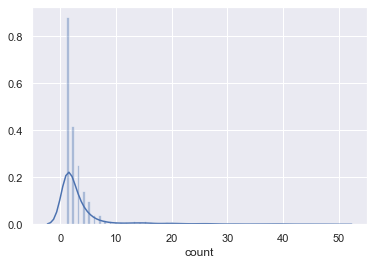

In [105]:
# look at the distribution of how many times songs are played
sns.set(color_codes = True)
x = dfp['count']
filtered = x[(x >= 0) & (x < 50)]
sns.distplot(filtered, bins = 100)

In [106]:
favs = dfp[dfp['count']>=10]

In [107]:
favs.head()

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,count,artist
116,Don't Play With It (feat. Young Thug),0.921,0.372,1,-14.841,0,0.232,0.00887,0.000221,0.0813,...,139.987,audio_features,4Lg4amkojlVz5FQtbH0e3C,spotify:track:4Lg4amkojlVz5FQtbH0e3C,https://api.spotify.com/v1/tracks/4Lg4amkojlVz...,https://api.spotify.com/v1/audio-analysis/4Lg4...,250723,4,15,Gunna
141,Beach Ballin' (feat. blackbear),0.689,0.586,1,-6.522,0,0.141,0.06430,0.000000,0.1200,...,160.037,audio_features,0W9E3s2G4szLUwXsE17x5E,spotify:track:0W9E3s2G4szLUwXsE17x5E,https://api.spotify.com/v1/tracks/0W9E3s2G4szL...,https://api.spotify.com/v1/audio-analysis/0W9E...,204275,4,19,Yung Pinch
162,Big Mood,0.677,0.434,5,-8.966,0,0.130,0.60800,0.000000,0.1200,...,199.952,audio_features,3CAqgqqx023Rff8tCQtsBz,spotify:track:3CAqgqqx023Rff8tCQtsBz,https://api.spotify.com/v1/tracks/3CAqgqqx023R...,https://api.spotify.com/v1/audio-analysis/3CAq...,138465,4,27,PAST
188,Big Mood,0.677,0.434,5,-8.966,0,0.130,0.60800,0.000000,0.1200,...,199.952,audio_features,3CAqgqqx023Rff8tCQtsBz,spotify:track:3CAqgqqx023Rff8tCQtsBz,https://api.spotify.com/v1/tracks/3CAqgqqx023R...,https://api.spotify.com/v1/audio-analysis/3CAq...,138465,4,27,Jason Garcia
317,Lemonade,0.744,0.385,6,-8.129,0,0.602,0.10400,0.000024,0.1240,...,160.033,audio_features,26qQf1Wmyy3ZZkagqCu5kp,spotify:track:26qQf1Wmyy3ZZkagqCu5kp,https://api.spotify.com/v1/tracks/26qQf1Wmyy3Z...,https://api.spotify.com/v1/audio-analysis/26qQ...,132000,4,19,Vic Sage


In [111]:
favs['count_bins'] = pd.cut(favs['count'], bins=10)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [112]:
favs.head()

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,count,artist,count_bins
116,Don't Play With It (feat. Young Thug),0.921,0.372,1,-14.841,0,0.232,0.00887,0.000221,0.0813,...,audio_features,4Lg4amkojlVz5FQtbH0e3C,spotify:track:4Lg4amkojlVz5FQtbH0e3C,https://api.spotify.com/v1/tracks/4Lg4amkojlVz...,https://api.spotify.com/v1/audio-analysis/4Lg4...,250723,4,15,Gunna,"(9.815, 28.5]"
141,Beach Ballin' (feat. blackbear),0.689,0.586,1,-6.522,0,0.141,0.06430,0.000000,0.1200,...,audio_features,0W9E3s2G4szLUwXsE17x5E,spotify:track:0W9E3s2G4szLUwXsE17x5E,https://api.spotify.com/v1/tracks/0W9E3s2G4szL...,https://api.spotify.com/v1/audio-analysis/0W9E...,204275,4,19,Yung Pinch,"(9.815, 28.5]"
162,Big Mood,0.677,0.434,5,-8.966,0,0.130,0.60800,0.000000,0.1200,...,audio_features,3CAqgqqx023Rff8tCQtsBz,spotify:track:3CAqgqqx023Rff8tCQtsBz,https://api.spotify.com/v1/tracks/3CAqgqqx023R...,https://api.spotify.com/v1/audio-analysis/3CAq...,138465,4,27,PAST,"(9.815, 28.5]"
188,Big Mood,0.677,0.434,5,-8.966,0,0.130,0.60800,0.000000,0.1200,...,audio_features,3CAqgqqx023Rff8tCQtsBz,spotify:track:3CAqgqqx023Rff8tCQtsBz,https://api.spotify.com/v1/tracks/3CAqgqqx023R...,https://api.spotify.com/v1/audio-analysis/3CAq...,138465,4,27,Jason Garcia,"(9.815, 28.5]"
317,Lemonade,0.744,0.385,6,-8.129,0,0.602,0.10400,0.000024,0.1240,...,audio_features,26qQf1Wmyy3ZZkagqCu5kp,spotify:track:26qQf1Wmyy3ZZkagqCu5kp,https://api.spotify.com/v1/tracks/26qQf1Wmyy3Z...,https://api.spotify.com/v1/audio-analysis/26qQ...,132000,4,19,Vic Sage,"(9.815, 28.5]"


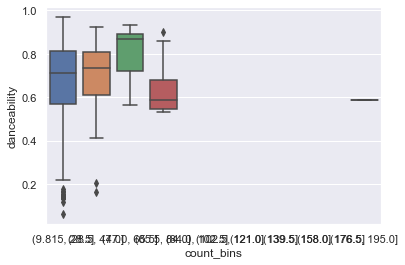

In [117]:
sns.boxplot(x=favs.count_bins,y=favs.danceability)

In [114]:
# was curious as to what song I played so many times
# study music needs to be removed
topsongalltime = dfp[dfp['count']>=150]
topsongalltime.head()

In [120]:
favs.drop(favs.loc[favs['count']>=150].index, inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [125]:
# luckily I just listened to that one song on loop 
favs[favs['count']>50]

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,count,artist,count_bins
2497,Heartthrob,0.892,0.561,11,-7.276,0,0.2260,0.02390,0.000003,0.1330,...,audio_features,4PFWDQTCDV6DqUYHVdupPt,spotify:track:4PFWDQTCDV6DqUYHVdupPt,https://api.spotify.com/v1/tracks/4PFWDQTCDV6D...,https://api.spotify.com/v1/audio-analysis/4PFW...,136901,4,54,Kris Hollis,"(47.0, 65.5]"
2626,Can't Stop,0.618,0.938,9,-3.442,1,0.0456,0.01790,0.000000,0.1670,...,audio_features,3ZOEytgrvLwQaqXreDs2Jx,spotify:track:3ZOEytgrvLwQaqXreDs2Jx,https://api.spotify.com/v1/tracks/3ZOEytgrvLwQ...,https://api.spotify.com/v1/audio-analysis/3ZOE...,269000,4,77,Young Don,"(65.5, 84.0]"
3364,Star,0.585,0.471,4,-9.934,0,0.0616,0.09670,0.018400,0.1150,...,audio_features,30bqVoKjX479ab90a8Pafp,spotify:track:30bqVoKjX479ab90a8Pafp,https://api.spotify.com/v1/tracks/30bqVoKjX479...,https://api.spotify.com/v1/audio-analysis/30bq...,142000,4,75,Ronny J,"(65.5, 84.0]"
3411,Star,0.585,0.471,4,-9.934,0,0.0616,0.09670,0.018400,0.1150,...,audio_features,30bqVoKjX479ab90a8Pafp,spotify:track:30bqVoKjX479ab90a8Pafp,https://api.spotify.com/v1/tracks/30bqVoKjX479...,https://api.spotify.com/v1/audio-analysis/30bq...,142000,4,75,AYO ^,"(65.5, 84.0]"
3737,Spirit Singin,0.910,0.513,10,-6.566,0,0.0971,0.11700,0.000004,0.2310,...,audio_features,17t7zyEQGjxQX8DuJpj0Y1,spotify:track:17t7zyEQGjxQX8DuJpj0Y1,https://api.spotify.com/v1/tracks/17t7zyEQGjxQ...,https://api.spotify.com/v1/audio-analysis/17t7...,204509,4,60,Tidus,"(47.0, 65.5]"
5375,Bad Boy,0.861,0.820,1,-4.807,0,0.0728,0.03200,0.000005,0.0706,...,audio_features,1dtTRXifeGC51adYy0902s,spotify:track:1dtTRXifeGC51adYy0902s,https://api.spotify.com/v1/tracks/1dtTRXifeGC5...,https://api.spotify.com/v1/audio-analysis/1dtT...,187571,4,70,Yung Bae,"(65.5, 84.0]"
7212,No Advice,0.876,0.692,2,-3.625,0,0.0857,0.57700,0.000000,0.1050,...,audio_features,0a0s72FJMtGpvUZ9n4lSKZ,spotify:track:0a0s72FJMtGpvUZ9n4lSKZ,https://api.spotify.com/v1/tracks/0a0s72FJMtGp...,https://api.spotify.com/v1/audio-analysis/0a0s...,157714,4,64,Skizzy Mars,"(47.0, 65.5]"
7490,"Runnin (with A$AP Rocky, A$AP Ferg & Nicki Minaj)",0.545,0.975,10,-3.193,0,0.4540,0.17000,0.000000,0.1450,...,audio_features,23dwrzeJtEEGl2U4CPWSor,spotify:track:23dwrzeJtEEGl2U4CPWSor,https://api.spotify.com/v1/tracks/23dwrzeJtEEG...,https://api.spotify.com/v1/audio-analysis/23dw...,131674,5,66,Mike WiLL Made-It,"(65.5, 84.0]"
9799,High Right Now,0.703,0.557,4,-6.798,0,0.0438,0.01160,0.000098,0.1200,...,audio_features,18LhA0zBzAa2YnhcN3hWGa,spotify:track:18LhA0zBzAa2YnhcN3hWGa,https://api.spotify.com/v1/tracks/18LhA0zBzAa2...,https://api.spotify.com/v1/audio-analysis/18Lh...,163168,4,55,Tyla Yaweh,"(47.0, 65.5]"
11443,ROXANNE,0.621,0.601,6,-5.616,0,0.1480,0.05220,0.000000,0.4600,...,audio_features,696DnlkuDOXcMAnKlTgXXK,spotify:track:696DnlkuDOXcMAnKlTgXXK,https://api.spotify.com/v1/tracks/696DnlkuDOXc...,https://api.spotify.com/v1/audio-analysis/696D...,163636,5,57,Arizona Zervas,"(47.0, 65.5]"


# Kaggle 160k Dataset 

In [139]:
kaggle = pd.read_csv("./Kaggle160kData/data.csv")

In [142]:
# Out of personal preference I only want to consider songs released after 1990
kaggle = kaggle[kaggle['year'] >= 1990]

# Playlist Analysis

In [20]:
sourcePlaylist = sp.user_playlist("kunalr", "3F20w43v5tF4DZShDF00j1")
tracks = sourcePlaylist["tracks"]
songs = tracks["items"] 
while tracks['next']:
    tracks = sp.next(tracks)
    for item in tracks["items"]:
        songs.append(item)

In [21]:
playlist = sp.user_playlist("kunalr", "3F20w43v5tF4DZShDF00j1")
tracks = playlist['tracks']['items']
next_uri = playlist['tracks']['next']
for _ in range(int(playlist['tracks']['total'] / playlist['tracks']['limit'])):
    response = sp._get(next_uri)
    tracks += response['items']
    next_uri = response['next']

tracks_df = pd.DataFrame([(track['track']['id'],
                           track['track']['artists'][0]['name'],
                           track['track']['name'],
                           parse_date(track['track']['album']['release_date']) if track['track']['album']['release_date'] else None,
                           parse_date(track['added_at']))
                          for track in playlist['tracks']['items']],
                         columns=['id', 'artist', 'name', 'release_date', 'added_at'] )

In [22]:
tracks_df.head()

,id,artist,name,release_date,added_at
0,46eb8Lsy2crHrKaacjCaiK,DP Rilla,Can't Lose,2019-01-25,2019-12-10 04:52:27+00:00
1,7GcbUQUvw2TIfmDfya8Jgv,IDK,Digital,2019-09-04,2019-12-10 04:52:37+00:00
2,02TmyBZCgcVihv9PVK9Mw2,Yung Gravy,iunno,2019-11-29,2019-12-10 04:52:50+00:00
3,0RMmzG0f5szIxC49oucu8w,Leeky Bandz,Picasso (feat. Gunna),2019-11-08,2019-12-10 04:53:02+00:00
4,0fySG6A6qLE8IvDpayb5bM,DaBaby,VIBEZ,2019-09-27,2019-12-10 04:53:13+00:00


In [23]:
tracks_df \
    .groupby('artist') \
    .count()['id'] \
    .reset_index() \
    .sort_values('id', ascending=False) \
    .rename(columns={'id': 'amount'}) \
    .head(10)

,artist,amount
0,24kGoldn,2
15,DaBaby,2
73,Young Thug,2
71,Vic Mensa,2
63,Rae Sremmurd,2
48,Meek Mill,2
44,Lil Tecca,2
35,Justin Starling,2
34,Juice WRLD,2
32,Johnny Yukon,2


In [24]:
counted_year_df = tracks_df \
    .assign(year_added=tracks_df.added_at.dt.year) \
    .groupby(['artist', 'year_added']) \
    .count()['id'] \
    .reset_index() \
    .rename(columns={'id': 'amount'}) \
    .sort_values('amount', ascending=False)

in_top_5_year_artist = counted_year_df \
    .groupby('year_added') \
    .head(5) \
    .artist \
    .unique()

counted_year_df \
    [counted_year_df.artist.isin(in_top_5_year_artist)] \
    .pivot('artist', 'year_added', 'amount') \
    .fillna(0) \
    .style.background_gradient()

year_added,2019,2020
artist,,
24kGoldn,0,2
DaBaby,2,0
Johnny Yukon,2,0
Meek Mill,2,0
Moeazy,0,1
OnCue,0,1
PH4DE,0,1
Playboi Carti,0,1
Vic Mensa,2,0


In [25]:
features = []
for n, chunk_series in tracks_df.groupby(np.arange(len(tracks_df)) // 50).id:
    features += sp.audio_features([*map(str, chunk_series)])
features_df = pd.DataFrame.from_dict(filter(None, features))
tracks_with_features_df = tracks_df.merge(features_df, on=['id'], how='inner')

In [26]:
tracks_with_features_df.head()

,id,artist,name,release_date,added_at,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,46eb8Lsy2crHrKaacjCaiK,DP Rilla,Can't Lose,2019-01-25,2019-12-10 04:52:27+00:00,0.649,0.795,7,-7.102,1,...,0.0516,0.142,0.571,160.047,audio_features,spotify:track:46eb8Lsy2crHrKaacjCaiK,https://api.spotify.com/v1/tracks/46eb8Lsy2crH...,https://api.spotify.com/v1/audio-analysis/46eb...,219141,4
1,7GcbUQUvw2TIfmDfya8Jgv,IDK,Digital,2019-09-04,2019-12-10 04:52:37+00:00,0.758,0.522,1,-4.717,1,...,0.0000,0.590,0.304,158.042,audio_features,spotify:track:7GcbUQUvw2TIfmDfya8Jgv,https://api.spotify.com/v1/tracks/7GcbUQUvw2TI...,https://api.spotify.com/v1/audio-analysis/7Gcb...,202578,4
2,02TmyBZCgcVihv9PVK9Mw2,Yung Gravy,iunno,2019-11-29,2019-12-10 04:52:50+00:00,0.908,0.402,0,-11.701,0,...,0.0000,0.066,0.569,86.005,audio_features,spotify:track:02TmyBZCgcVihv9PVK9Mw2,https://api.spotify.com/v1/tracks/02TmyBZCgcVi...,https://api.spotify.com/v1/audio-analysis/02Tm...,157674,4
3,0RMmzG0f5szIxC49oucu8w,Leeky Bandz,Picasso (feat. Gunna),2019-11-08,2019-12-10 04:53:02+00:00,0.820,0.643,1,-6.272,1,...,0.0000,0.112,0.127,140.003,audio_features,spotify:track:0RMmzG0f5szIxC49oucu8w,https://api.spotify.com/v1/tracks/0RMmzG0f5szI...,https://api.spotify.com/v1/audio-analysis/0RMm...,192000,4
4,0fySG6A6qLE8IvDpayb5bM,DaBaby,VIBEZ,2019-09-27,2019-12-10 04:53:13+00:00,0.768,0.652,1,-2.708,0,...,0.0000,0.107,0.777,154.187,audio_features,spotify:track:0fySG6A6qLE8IvDpayb5bM,https://api.spotify.com/v1/tracks/0fySG6A6qLE8...,https://api.spotify.com/v1/audio-analysis/0fyS...,144935,4


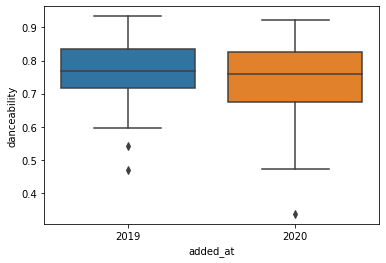

In [27]:
sns.boxplot(x=tracks_with_features_df.added_at.dt.year,
            y=tracks_with_features_df.danceability)

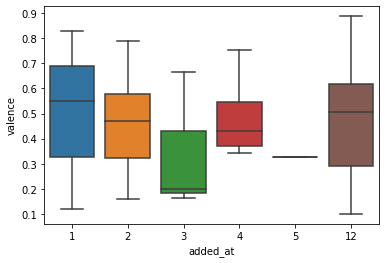

In [28]:
sns.boxplot(x=tracks_with_features_df.added_at.dt.month,
            y=tracks_with_features_df.valence)

In [29]:
encode_fields = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'time_signature',
]

def encode(row):
    return np.array([
        (row[k] - tracks_with_features_df[k].min())
        / (tracks_with_features_df[k].max() - tracks_with_features_df[k].min())
        for k in encode_fields])

tracks_with_features_encoded_df = tracks_with_features_df.assign(
    encoded=tracks_with_features_df.apply(encode, axis=1))

In [30]:
tracks_with_features_encoded_product_df = tracks_with_features_encoded_df \
    .assign(temp=0) \
    .merge(tracks_with_features_encoded_df.assign(temp=0), on='temp', how='left') \
    .drop(columns='temp')
tracks_with_features_encoded_product_df = tracks_with_features_encoded_product_df[
    tracks_with_features_encoded_product_df.id_x != tracks_with_features_encoded_product_df.id_y
]
tracks_with_features_encoded_product_df['merge_id'] = tracks_with_features_encoded_product_df \
    .apply(lambda row: ''.join(sorted([row['id_x'], row['id_y']])), axis=1)
tracks_with_features_encoded_product_df['distance'] = tracks_with_features_encoded_product_df \
    .apply(lambda row: np.linalg.norm(row['encoded_x'] - row['encoded_y']), axis=1)

In [31]:
# most similar songs
tracks_with_features_encoded_product_df \
    .sort_values('distance') \
    .drop_duplicates('merge_id') \
    [['artist_x', 'name_x', 'release_date_x', 'artist_y', 'name_y', 'release_date_y', 'distance']] \
    .head(10)

,artist_x,name_x,release_date_x,artist_y,name_y,release_date_y,distance
514,NGHTMRE,CASH COW,2019-11-15,Vic Mensa,Reverse (Ft. G-Eazy),2018-06-08,0.233973
519,NGHTMRE,CASH COW,2019-11-15,Johnny Yukon,First Night,2018-05-04,0.239458
7774,Alexander Lewis,Layaway,2019-11-22,Kendrick Lamar,Big Shot (with Travis Scott),2018-02-09,0.259545
8174,Playboi Carti,Shoota (feat. Lil Uzi Vert),2018-05-11,HDBeenDope,Bands 2,2020-01-27,0.276665
3202,The Seige,Rage,2017-11-04,24kGoldn,VALENTINO,2019-01-25,0.306404
4971,Vic Mensa,Reverse (Ft. G-Eazy),2018-06-08,Leeky Bandz,Picasso (feat. Gunna),2019-11-08,0.314742
6308,Derek Pope,I Can't Trust My Mind (feat. Berner),2019-09-13,KYLE,Moment (feat. Wiz Khalifa),2018-08-24,0.316755
1102,mike.,The Way to Go,2019-04-19,Kap G,The Bomb,2019-11-15,0.318706
1188,Benny D,Code Red,2019-01-21,Alexander Lewis,Layaway,2019-11-22,0.331164
5027,Vic Mensa,Reverse (Ft. G-Eazy),2018-06-08,Johnny Yukon,First Night,2018-05-04,0.373529


In [32]:
# average songs
tracks_with_features_encoded_product_df \
    .groupby(['artist_x', 'name_x', 'release_date_x']) \
    .sum()['distance'] \
    .reset_index() \
    .sort_values('distance') \
    .head(10)

,artist_x,name_x,release_date_x,distance
66,Ohana Bam,Susie,2019-03-06,93.718364
1,24kGoldn,VALENTINO,2019-01-25,101.486824
54,Lil Uzi Vert,Sanguine Paradise,2019-04-09,101.856750
78,The Seige,Rage,2017-11-04,101.999748
46,Kap G,The Bomb,2019-11-15,102.184043
31,Indica,TIME MACHINE,2019-02-22,102.524292
79,Towkio,2 Da Moon,2018-05-18,102.936658
27,HDBeenDope,Bands 2,2020-01-27,102.992936
86,Young Thug,The London (feat. J. Cole & Travis Scott),2019-05-23,103.164081
70,Playboi Carti,Shoota (feat. Lil Uzi Vert),2018-05-11,103.206136


In [33]:
# outlier songs
tracks_with_features_encoded_product_df \
    .groupby(['artist_x', 'name_x', 'release_date_x']) \
    .sum()['distance'] \
    .reset_index() \
    .sort_values('distance', ascending=False) \
    .head(10)

,artist_x,name_x,release_date_x,distance
91,mike.,These Days,2015-10-30,145.736637
44,KTOE,Touring,2019-03-01,142.572173
84,Vita Flare,PABLO,2020-02-05,137.524536
34,Jaden,GOKU,2018-10-05,133.699635
69,Party Pupils,Me No Evil - Party Pupils Remix,2020-03-16,133.219435
56,Louis The Child,Shake Something (feat. Joey Purp),2018-03-08,132.037184
23,Famous Dex,JAPAN,2018-04-06,130.522790
0,24kGoldn,DROPPED OUTTA COLLEGE,2019-11-22,130.284483
10,Big Sean,Who's Stopping Me (& Metro Boomin),2017-12-08,129.932446
62,Moeazy,Dracula,2019-07-31,129.032655
